## Business Problem

Adopted 

## impot data and library

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# import libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import validation_curve


In [3]:
# check log data
log = pd.read_csv('takehome_user_engagement.csv')
log.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
#change datetime to datetime format
log.time_stamp = log.time_stamp.astype('datetime64[ns]')

In [5]:
# check the log info
log.info()
log.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


time_stamp    0
user_id       0
visited       0
dtype: int64

In [6]:
# check user data
user = pd.read_csv('takehome_users.csv')
user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [7]:
# check user info
user.info()
user.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

## Method 1:

1. based on log data figure out adopted userid and not adopted
2. join with member data
3. classification model for findng the factor that effect the correlation rate

### create adopted user

In [8]:
# glimpse
log.sort_values(['user_id','time_stamp']).head(10)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
5,2013-12-31 03:45:04,2,1
6,2014-01-08 03:45:04,2,1
7,2014-02-03 03:45:04,2,1
8,2014-02-08 03:45:04,2,1
9,2014-02-09 03:45:04,2,1


In [9]:
# each row seperate day and user_id
log['YMD'] = log['time_stamp'].dt.to_period('D')
log.head()

,time_stamp,user_id,visited,YMD
0,2014-04-22 03:53:30,1,1,2014-04-22
1,2013-11-15 03:45:04,2,1,2013-11-15
2,2013-11-29 03:45:04,2,1,2013-11-29
3,2013-12-09 03:45:04,2,1,2013-12-09
4,2013-12-25 03:45:04,2,1,2013-12-25


In [10]:
# same day visit count as 1 visit (initial 207917 row, after agg 207917 row)
log.groupby(['YMD','user_id']).mean('visited').reset_index()

,YMD,user_id,visited
0,2012-05-31,1693,1
1,2012-05-31,3428,1
2,2012-05-31,9899,1
3,2012-05-31,10012,1
4,2012-06-01,1995,1
...,...,...,...
207912,2014-06-04,11885,1
207913,2014-06-04,11895,1
207914,2014-06-04,11906,1
207915,2014-06-04,11924,1


In [11]:
# group by 7 days
active_time = log.groupby(['user_id', pd.Grouper(key= 'time_stamp', freq='7D')]).agg({
'visited': sum
}).reset_index()

In [12]:
active_time.head()

,user_id,time_stamp,visited
0,1,2014-04-17,1
1,2,2013-11-14,1
2,2,2013-11-28,1
3,2,2013-12-05,1
4,2,2013-12-19,1


In [13]:
# set adoptedUser or not
adoptedUser = active_time.groupby('user_id')['visited'].max().to_frame().reset_index()
adoptedUser['adopted'] = [1 if i>=3 else 0 for i in adoptedUser['visited']]

### join user type with features

In [14]:
# glimpse
user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [15]:
# merge two table
df = pd.merge(user, adoptedUser[['user_id','adopted']], how='right', left_on='object_id', right_on='user_id')

In [180]:
# create column "age of account"
df['creation_time'] = pd.to_datetime(df['creation_time'])

In [196]:
# age of account in year
df['age of account'] = (pd.to_datetime('2022-02-09 00:00:01') - df['creation_time'])
df['age of account'] = df['age of account'].astype('timedelta64[Y]')

### Build classifier and check the most important feature

#### data wrangling

In [197]:
# glimpse
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,adopted,age of account
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1,0,7.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2,0,8.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,3,0,8.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,4,0,8.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,5,0,9.0


In [198]:
# check join by key
sum(df['object_id'] != df['user_id'])

0

In [199]:
# select column for building models
#selected_col = ['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip','invited_by_user_id', 'org_id','adopted']
selected_col = ['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip','age of account', 'adopted']

In [200]:
# df_selected for training purpose
df_selected = df[selected_col]
df_selected.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,age of account,adopted
0,GUEST_INVITE,1,0,7.0,0
1,ORG_INVITE,0,0,8.0,0
2,ORG_INVITE,0,0,8.0,0
3,GUEST_INVITE,0,0,8.0,0
4,GUEST_INVITE,0,0,9.0,0


In [201]:
# all cat vals, if too many unique values, overfit?
print('num of unique org id: ',len(df_selected.org_id.unique()))
print('num of unique invited by user', len(df_selected.invited_by_user_id.unique()))

AttributeError: 'DataFrame' object has no attribute 'org_id'

In [204]:
org_id_uni, org_id_counts = np.unique(df_selected.org_id, return_counts=True)
# we can compress it to 15+1 cats
org_id_idx = np.argsort(org_id_counts)

sns.scatterplot(range(len(org_id_counts)), org_id_counts[org_id_idx[::-1]])
sns.lineplot([15,15],[0,300],color='red')
plt.legend()
plt.xlabel('unique value')
plt.ylabel('frequency')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'org_id'

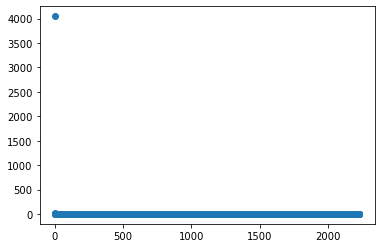

In [205]:
invited_uni, invited_counts = np.unique(df['invited_by_user_id'], return_counts=True)
invited_idx = np.argsort(invited_counts)
# we can compress it to 15+1 cats
plt.scatter(range(len(invited_counts)), invited_counts[invited_idx[::-1]])
plt.show()

In [207]:
# recode data
# org_id recode to top x cats
org_id_x = org_id_uni[org_id_idx[-20:]]
df_selected['org_id'] = df_selected['org_id'].apply(lambda x: x if x in org_id_x else 'other')
#df_selected 
# invited_by_user_id to invited or not invited
df_selected['invited_by_user_id']= df_selected['invited_by_user_id'].apply(lambda x: 0 if np.isnan(x) else 1)

KeyError: 'org_id'

### train

In [208]:
# change data type to cat
for col in df_selected.columns:
    if col not in ['adopted','org_id']:
        df_selected[col] = df_selected[col].astype('object')

<ipython-input-208-cd2fd4fad93c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected[col] = df_selected[col].astype('object')


In [210]:
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 8822
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   creation_source             8823 non-null   object
 1   opted_in_to_mailing_list    8823 non-null   object
 2   enabled_for_marketing_drip  8823 non-null   object
 3   age of account              8823 non-null   object
 4   adopted                     8823 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 671.6+ KB


In [211]:
# split into train and test
X_train, X_test, y_train, y_test= train_test_split(pd.get_dummies(df_selected.drop(columns=['adopted']), drop_first=True),
 df_selected['adopted'],test_size=0.25, random_state=42)

In [212]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6617, 8) (6617,)
(2206, 8) (2206,)


In [213]:
# under sampling
us = RandomUnderSampler()
X_train_us, y_train_us= us.fit_resample(X_train, y_train)
print(X_train_us.shape, y_train_us.shape)

(2128, 8) (2128,)


In [214]:
# smote
sm = SMOTE()
X_train_sm, y_train_sm= sm.fit_resample(X_train, y_train)
print(X_train_sm.shape, y_train_sm.shape)

(11106, 8) (11106,)


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


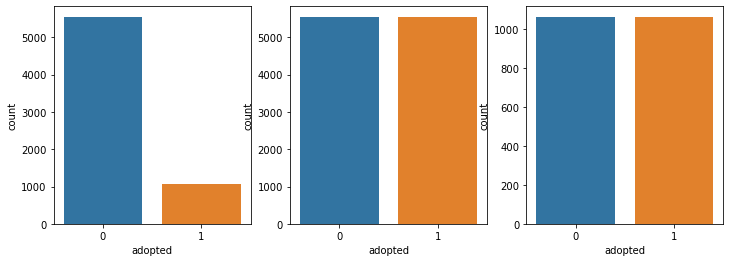

In [215]:
# check imbalance and adjust imbalance
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); sns.countplot(y_train)
plt.subplot(1,3,2); sns.countplot(y_train_sm)
plt.subplot(1,3,3); sns.countplot(y_train_us)
plt.show()

In [216]:
X_train_sm.head()

,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,opted_in_to_mailing_list_1,enabled_for_marketing_drip_1,age of account_8.0,age of account_9.0
0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


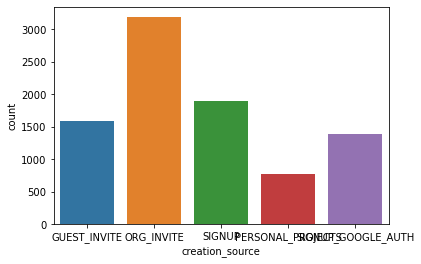

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


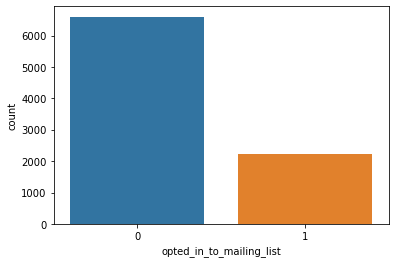

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


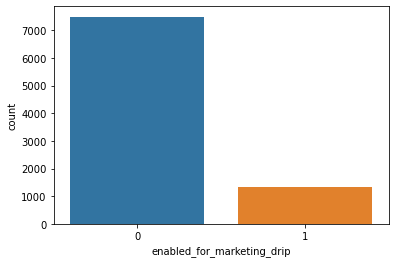

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


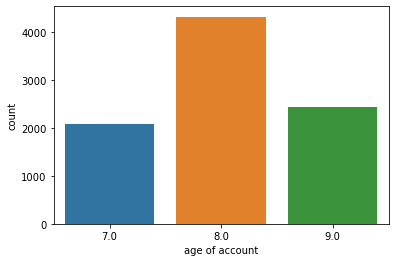

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


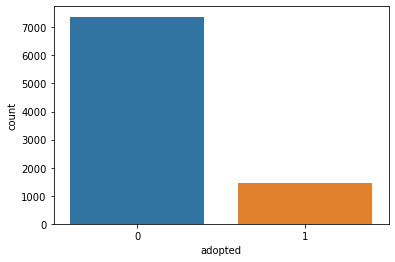

In [217]:
for col in df_selected.columns:
    sns.countplot(df_selected[col])
    plt.show()

#### Feature importance

##### Random Forest

In [218]:
# random forest fit smote data
rfc_sm = RandomForestClassifier(n_estimators=100, max_depth= 15)
rfc_sm.fit(X_train_sm, y_train_sm)

RandomForestClassifier(max_depth=15)

In [219]:
# random forest predict test
y_pred_sm = rfc_sm.predict(X_test)
y_prob_sm = rfc_sm.predict_proba(X_test)

In [220]:
print(classification_report(y_true=y_test, y_pred= y_pred_sm))
print('roc_auc_score: ', roc_auc_score(y_true=y_test, y_score=y_prob_sm[:,1]))

              precision    recall  f1-score   support

           0       0.88      0.51      0.64      1825
           1       0.22      0.66      0.33       381

    accuracy                           0.53      2206
   macro avg       0.55      0.58      0.49      2206
weighted avg       0.76      0.53      0.59      2206

roc_auc_score:  0.6290590730953152


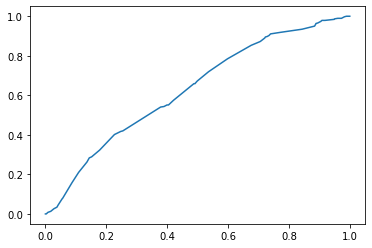

In [221]:
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_prob_sm[:,1])
plt.plot(fpr, tpr)
plt.show()

In [222]:
# print important features
feature_imp_idx = np.argsort(rfc_sm.feature_importances_)[::-1]
X_train.columns[feature_imp_idx]

Index(['age of account_9.0', 'age of account_8.0',
       'enabled_for_marketing_drip_1', 'opted_in_to_mailing_list_1',
       'creation_source_SIGNUP', 'creation_source_ORG_INVITE',
       'creation_source_SIGNUP_GOOGLE_AUTH',
       'creation_source_PERSONAL_PROJECTS'],
      dtype='object')

In [223]:
# grid search CV for randdom forest
rfc = RandomForestClassifier()
rfc_params = {'n_estimators': [round(i) for i in np.logspace(2,3,3)], 'max_depth':range(10,12,1) }
rfc_cv = GridSearchCV(rfc, param_grid=rfc_params, cv=5, return_train_score=True)

In [224]:
rfc_cv.fit(X_train_sm,y_train_sm)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(10, 12),
                         'n_estimators': [100, 316, 1000]},
             return_train_score=True)

In [225]:
y_pred_cv = rfc_cv.predict(X_test)
y_prob_cv = rfc_cv.predict_proba(X_test)

n_estimator [ 100.          316.22776602 1000.        ] max_depth range(10, 12)


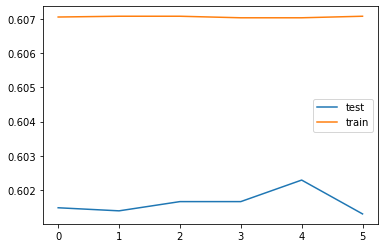

In [226]:
print('n_estimator', np.logspace(2,3,3), 'max_depth',range(10,12,1))
# test from results directly
test_scores = rfc_cv.cv_results_['mean_test_score']
train_scores = rfc_cv.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

In [227]:
'''
# test training and test
train_scores, test_scores = validation_curve(
    RandomForestClassifier(),
    X_train_sm,
    y_train_sm,
    param_name="max_depth",
    param_range=range(4,15,1),
    scoring="accuracy",
    n_jobs=2,
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with RFC")
plt.xlabel("max_depth")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(
    range(4,15,1), train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    range(4,15,1),
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    range(4,15,1), test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    range(4,15,1),
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()
'''

'\n# test training and test\ntrain_scores, test_scores = validation_curve(\n    RandomForestClassifier(),\n    X_train_sm,\n    y_train_sm,\n    param_name="max_depth",\n    param_range=range(4,15,1),\n    scoring="accuracy",\n    n_jobs=2,\n)\ntrain_scores_mean = np.mean(train_scores, axis=1)\ntrain_scores_std = np.std(train_scores, axis=1)\ntest_scores_mean = np.mean(test_scores, axis=1)\ntest_scores_std = np.std(test_scores, axis=1)\n\nplt.title("Validation Curve with RFC")\nplt.xlabel("max_depth")\nplt.ylabel("Score")\nplt.ylim(0.0, 1.1)\nlw = 2\nplt.semilogx(\n    range(4,15,1), train_scores_mean, label="Training score", color="darkorange", lw=lw\n)\nplt.fill_between(\n    range(4,15,1),\n    train_scores_mean - train_scores_std,\n    train_scores_mean + train_scores_std,\n    alpha=0.2,\n    color="darkorange",\n    lw=lw,\n)\nplt.semilogx(\n    range(4,15,1), test_scores_mean, label="Cross-validation score", color="navy", lw=lw\n)\nplt.fill_between(\n    range(4,15,1),\n    test

In [228]:
rfc_cv.best_estimator_

RandomForestClassifier(max_depth=11, n_estimators=316)

In [229]:
print(classification_report(y_pred=y_pred_cv, y_true = y_test))
print(roc_auc_score(y_score=y_prob_cv.T[1,:], y_true=y_test))

              precision    recall  f1-score   support

           0       0.88      0.51      0.64      1825
           1       0.22      0.66      0.33       381

    accuracy                           0.53      2206
   macro avg       0.55      0.58      0.49      2206
weighted avg       0.76      0.53      0.59      2206

0.6299248552835004


##### Decision Tree

In [230]:
# decision tree
tc = DecisionTreeClassifier()
tc.fit(X_train_sm, y_train_sm)

DecisionTreeClassifier()

In [231]:
y_pred_tc = tc.predict(X_test)
y_prob_tc = tc.predict_proba(X_test)

In [232]:
print(classification_report(y_true=y_test, y_pred = y_pred_tc))
print(roc_auc_score(y_true=y_test, y_score=y_prob_tc[:,1]))

              precision    recall  f1-score   support

           0       0.88      0.51      0.64      1825
           1       0.22      0.66      0.33       381

    accuracy                           0.53      2206
   macro avg       0.55      0.58      0.49      2206
weighted avg       0.76      0.53      0.59      2206

0.6284262754826879


In [237]:
# grid search decision tree
tc_cv = GridSearchCV(DecisionTreeClassifier(), \
    param_grid={'max_depth':np.arange(1,5),'min_samples_split':[2]},\
    return_train_score=True, scoring='precision')

In [238]:
_ = tc_cv.fit(X_train_sm, y_train_sm)
y_pred_tc_cv = tc_cv.predict(X_test)
y_prob_tc_cv = tc_cv.predict_proba(X_test)

n_estimator [ 100.          316.22776602 1000.        ] max_depth range(10, 12)


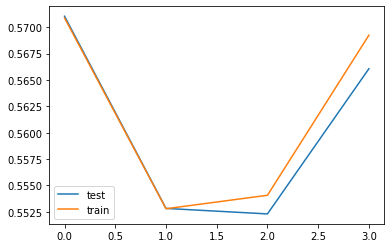

In [239]:
print('n_estimator', np.logspace(2,3,3), 'max_depth',range(10,12,1))
# test from results directly
tc_cv_test_scores = tc_cv.cv_results_['mean_test_score']
tc_cv_train_scores = tc_cv.cv_results_['mean_train_score'] 

plt.plot(tc_cv_test_scores, label='test')
plt.plot(tc_cv_train_scores, label='train')
plt.legend(loc='best')
plt.show()

In [240]:
print(classification_report(y_true=y_test, y_pred = y_pred_tc_cv))
print(roc_auc_score(y_true=y_test, y_score=y_prob_tc_cv[:,1]))

              precision    recall  f1-score   support

           0       0.85      0.73      0.79      1825
           1       0.22      0.36      0.27       381

    accuracy                           0.67      2206
   macro avg       0.53      0.55      0.53      2206
weighted avg       0.74      0.67      0.70      2206

0.5460913961097328


In [241]:
tc_feature_imp_idx = np.argsort(tc.feature_importances_)[::-1]
X_train.columns[tc_feature_imp_idx]

Index(['age of account_8.0', 'enabled_for_marketing_drip_1',
       'age of account_9.0', 'opted_in_to_mailing_list_1',
       'creation_source_ORG_INVITE', 'creation_source_SIGNUP',
       'creation_source_SIGNUP_GOOGLE_AUTH',
       'creation_source_PERSONAL_PROJECTS'],
      dtype='object')

#### SVM

In [242]:
from sklearn.svm import SVC

In [49]:
SVCc = SVC(probability=True)
SVCc.fit(X_train_sm, y_train_sm)

SVC(probability=True)

In [50]:
y_pred_svc = SVCc.predict(X_test)
y_prob_svc = SVCc.predict_proba(X_test)

In [51]:
print(classification_report(y_true=y_test, y_pred = y_pred_svc))
print(roc_auc_score(y_true=y_test, y_score=y_prob_svc[:,1]))

              precision    recall  f1-score   support

           0       0.89      0.21      0.34      1825
           1       0.19      0.87      0.31       381

    accuracy                           0.33      2206
   macro avg       0.54      0.54      0.33      2206
weighted avg       0.77      0.33      0.34      2206

0.5898471937583144
